#Code for fitting different RL models to the ser/sim experiments

In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import patsy
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from sklearn import linear_model
import multiprocessing
import random
from scipy.stats import norm
from scipy.stats import beta
##Code for analysis of fMRI experiment

In [2]:
%matplotlib inline

#Read in and preprocess data

In [289]:
#Read in data
data_dir = os.path.abspath('../')
all_rts = pd.read_csv(data_dir + '/all_rts.csv', index_col =0)
exp_order = pd.read_csv(data_dir + '/exp_order.csv', index_col =0)
subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))
subjects = [s for s in subjects if s not in ['fd_143','fd_146']]
#some experiment variables
order_dict_ser = {'c_plus':6, 'b_plus':2, 'b_minus':3, 'c_minus':5} #coding for trial order vector
order_dict_sim = {'c_plus':4, 'b_plus':1, 'b_minus':2, 'c_minus':3}
# exp_conditions = ['c_plus','b_plus','b_minus','c_minus'] #coding for trial order vector
order_dict_exp = {'ser': order_dict_ser, 'sim':order_dict_sim}

#some global variables
trial_map = {'b_plus':'b_minus', 'b_minus' : 'b_plus', 
             'c_plus' : 'c_minus','c_minus':'c_plus'} #mapping for leaky RL models
a_beta, b_beta = 1.1, 1.1 #priors for
mu, sigma = 0, 4
num_runs  = 3

exp_order.ix[exp_order['rew'] == 0,'rew'] = -1 #balance reward so learning is even

In [4]:
#process the RTs a bit (remove trial types 1, 4, and 10 (see below) and mean center)
ser_rts = all_rts[all_rts['exp']=='ser']
ser_rts = ser_rts[ser_rts['order'] != 10] #ITI
ser_rts = ser_rts[ser_rts['order'] != 1] #A
ser_rts = ser_rts[ser_rts['order'] != 4] #A

sim_rts = all_rts[all_rts['exp']=='sim']
sim_rts = sim_rts[sim_rts['order'] != 10] #ITI

rt_dict_exp = {'ser': ser_rts, 'sim':sim_rts}

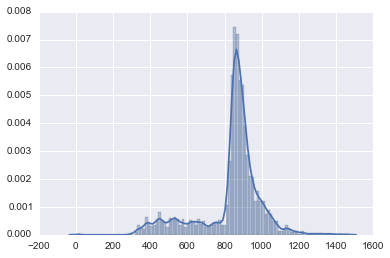

In [5]:
a = ser_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

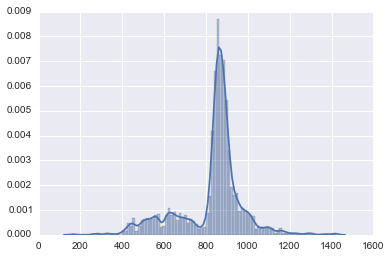

In [6]:
a = sim_rts.dropna()
a = a['rt'].values
a = [rt for rt in a if rt < 100000]
sns.distplot(a);

#Define RL models

In [263]:
def standard_RL(trial_order,rew_trial,alpha,exp):
    V = {'b_plus':[0], 'b_minus' : [0], 'c_plus' : [0],'c_minus':[0]}
    delta = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    index = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    PE_order = []
    order_dict = order_dict_exp[exp]
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = None
        for key in order_dict:
            if order_dict[key] == cond:
                trial_type = key
#         print cond, trial_type
        if trial_type is not None:
            rew = rew_trial[n]
            delta[trial_type].append(rew - V[trial_type][-1]) #compute PE
            new_V = V[trial_type][-1] + alpha * delta[trial_type][-1] #calculate V for next trial
            V[trial_type].append(new_V) 
            index[trial_type].append(count)
            count += 1 
    return V, delta, index
trial_order = [1, 2, 10, 6, 10, 6, 10, 4, 5, 10, 1, 2, 10, 3, 10, 1, 2, 10, 1, 2, 10, 1, 2, 10, 4, 5, 10, 4, 5, 10, 3, 10, 1, 2, 10, 4, 5, 10, 4, 5, 10, 6, 10, 3, 10, 4, 5, 10, 6, 10, 3, 10, 3, 10, 6, 10, 4, 5, 10, 3, 10, 6, 10, 1, 2, 10, 3, 10, 1, 2, 10, 4, 5, 10, 4, 5, 10, 6, 10, 3, 10, 6, 10, 1, 2, 10, 3, 10, 6, 10, 3, 10, 4, 5, 10, 6, 10, 1, 2, 10]
rew = [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
V, delta, index= standard_RL(trial_order,rew,.2,'ser')
print PE_order

[0, 1, 0.8, 1, 1.0, 0, 0.8, 0.6399999999999999, 0.512, -0.2, -0.16, 0.0, 0.40959999999999996, -0.128, -0.1024, 0.6399999999999999, 0.0, -0.08192, 0.512, 0.0, 0.0, -0.5904, 0.934464, 1.0, -0.47232, -0.67232, 0.8, 0.462144, -0.2524288, -0.20194304000000002, 0.622144, -0.36000000000000004, 0.4977152, 0.3697152, -0.28800000000000003, 0.39817216, 0.7696, 0.838445568, -0.681462272, -0.7042278399999999]


In [27]:
#This RL algorithm keeps one state representation for each event
def dumb_RL(trial_order,rew_trial,alpha,exp):    
    V = {'b_plus':[0], 'b_minus' : [0], 'c_plus' : [0],'c_minus':[0]}
    delta = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    index = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    order_dict = order_dict_exp[exp]
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = None
        for key in order_dict:
            if order_dict[key] == cond:
                trial_type = key
                
        if trial_type is not None:
            rew = rew_trial[n]
            
            #do correct RL update
            delta[trial_type].append(rew - V[trial_type][-1]) #compute PE
            new_V = V[trial_type][-1] + alpha * delta[trial_type][-1] #calculate V for next trial
            V[trial_type].append(new_V)
            
            #do the dumb update to the other trial type
            V[trial_map[trial_type]].pop() #remove old V
            V[trial_map[trial_type]].append(new_V)            
            
            index[trial_type].append(count)
            count += 1

    return V, delta, index

In [28]:
#augment RL algorithm to allow value to update to the other state
def leaky_RL(trial_order,rew_trial,rl_params,exp):
    alpha,d = rl_params
    V = {'b_plus':[0], 'b_minus' : [0], 'c_plus' : [0],'c_minus':[0]}
    delta1 = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    delta2 = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    index = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    order_dict = order_dict_exp[exp]
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = None
        for key in order_dict:
            if order_dict[key] == cond:
                trial_type = key
                
        if trial_type is not None:
            rew = rew_trial[n]
            
            #do correct RL update
            delta1[trial_type].append(rew - V[trial_type][-1]) #compute PE
            new_V = V[trial_type][-1] + alpha * delta1[trial_type][-1] #calculate V for next trial
            V[trial_type].append(new_V)
            
            #do leaky RL update
            delta2[trial_map[trial_type]].append(rew - V[trial_map[trial_type]][-1]) #compute PE
            new_V = V[trial_map[trial_type]][-1] + d*alpha * delta2[trial_map[trial_type]][-1] #calculate V for next trial
            V[trial_map[trial_type]].pop() #remove old V
            V[trial_map[trial_type]].append(new_V)            
            
            index[trial_type].append(count)
            count += 1 

    return V, delta1, index

In [29]:
def blend_RL(trial_order,rew_trial,rl_params,exp):
    alpha,d = rl_params
    V = {'b_plus':[0], 'b_minus' : [0], 'c_plus' : [0],'c_minus':[0]}
    delta = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    index = {'b_plus':[], 'b_minus' : [], 'c_plus' : [],'c_minus':[]}
    order_dict = order_dict_exp[exp]
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = None
        for key in order_dict:
            if order_dict[key] == cond:
                trial_type = key
                
        if trial_type is not None:
            rew = rew_trial[n]
            delta[trial_type].append(rew - V[trial_type][-1]) #compute PE
            new_V = V[trial_type][-1] + alpha * delta[trial_type][-1] #calculate V for next trial
            V[trial_type].append(new_V) 
            index[trial_type].append(count)
            count += 1
            
            #Decrement V towards one another
            avg_v = (V[trial_type][-1] + V[trial_map[trial_type]][-1])/2.0
            decrement = avg_v * d
            if V[trial_type][-1] < avg_v: 
                V[trial_type][-1] = V[trial_type][-1] + d * abs(avg_v - V[trial_type][-1])
                V[trial_map[trial_type]][-1] = V[trial_map[trial_type]][-1] - d * abs(avg_v - V[trial_map[trial_type]][-1])
            else:
                V[trial_type][-1] = V[trial_type][-1] - d * abs(avg_v - V[trial_type][-1])
                V[trial_map[trial_type]][-1] = V[trial_map[trial_type]][-1] + d * abs(avg_v - V[trial_map[trial_type]][-1])
            
    return V, delta, index

In [30]:
#double check that linear regression code works (given a fixed alpha)
clf = linear_model.LinearRegression(fit_intercept=False)
# clf.fit(X, y)
# clf.coef_

# Fit Data

In [31]:
#Z score normalize dataframe at each run for each experiment and each subject
def z_score_dataframe(predictors,exps):
    for sub in subjects:
        for exp in exps:
            for i in range(1,num_runs+1):
                run = 'run' + str(i)

                for i in range(1,num_runs+1):
                    predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp) & (predictors['run']==run),'rt'] \
                    =  predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp) & (predictors['run']==run),'rt'] - \
                    predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp) & (predictors['run']==run),'rt'].mean()  

                    predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp) & (predictors['run']==run),'rt'] \
                    =  predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp) & (predictors['run']==run),'rt'] / \
                    predictors.loc[(predictors['subject']==sub) & (predictors['exp']==exp) & (predictors['run']==run),'rt'].std() 
        
                #Z-score trial index for each row
                predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] - \
                predictors.loc[predictors['run']==run,'trial_index'].mean()
                predictors.loc[predictors['run']==run,'trial_index'] =  predictors.loc[predictors['run']==run,'trial_index'] / \
                predictors.loc[predictors['run']==run,'trial_index'].std()
    
    return predictors

In [153]:
##function for building dataframe of relevant data for each subject
def build_df(num_runs, subjects,exp_list):
    alpha = .1
    predictors = {'exp':[],'subject':[],'V':[],'PE':[],'run':[], 'cond':[], 'trial_index':[],'rt':[]}

    for i in range(1,num_runs+1):
        for exp in exp_list:
            order_dict = order_dict_exp[exp]
            ##perform RL for the experimental condition
            event_order = exp_order[exp_order['exp']==exp]
            rew = np.array(event_order[event_order['run']==i]['rew'])
            tt = np.array(event_order[event_order['run']==i]['trial_order'])
            V, delta, index = standard_RL(tt,rew,alpha,exp)
            for key in V.keys():
                V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist

            for sub in subjects:

                #get rt data for this subject and run
                rts = rt_dict_exp[exp]
                rt_data = rts[(rts['sub']==sub) & (rts['run']==i) ]

                ##update predictors dict
                for key in V.keys():
                    predictors['V'].extend(V[key])
                    predictors['PE'].extend(delta[key])
                    predictors['cond'].extend([key]*len(V[key]))
                    predictors['exp'].extend([exp]*len(V[key]))
                    predictors['subject'].extend([sub]*len(V[key]))
                    predictors['run'].extend(['run' + str(i)]*len(V[key]))
                    predictors['trial_index'].extend(index[key])
                    predictors['rt'].extend(rt_data[rt_data['order']==key]['rt'].values)

    predictors = pd.DataFrame(predictors)
    predictors = predictors.sort(['subject','run','trial_index']) #get predictors in proper order
    predictors = z_score_dataframe(predictors,exp_list)
    
    return predictors

In [33]:
#this function updates the predictors dataframe with the RL resylts
def do_rl(RL_func,exp_list,num_runs,subjects,predictors,rl_params):
    ##perform RL for the experimental condition
    for i in range(1,num_runs+1):
        for exp in exp_list:
            event_order = exp_order[exp_order['exp']==exp]
            rew = np.array(event_order[event_order['run']==i]['rew'])
            tt = np.array(event_order[event_order['run']==i]['trial_order'])
            V, delta, index = RL_func(tt,rew,rl_params,exp)

            for key in V.keys():
                V[key] = V[key][:-1] #last entry is for subsequent trial that doesnt exist 
                predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key)  & (predictors['exp'] == exp), 'V'] = V[key]*len(subjects)
                predictors.ix[(predictors['run'] == 'run' + str(i)) & (predictors['cond'] == key) & (predictors['exp'] == exp), 'PE'] = delta[key]*len(subjects)
    return predictors

In [157]:
##returns loss for linear regression
def regress_all(params,predictors,num_runs,subjects,RL_func,exp_list,bootstrap,MAP):
    if bootstrap: 
        alpha = scipy.stats.logistic.cdf(params)
        beta = [0.34157265 , 0.01219888, -0.78280317]
    elif RL_func.func_name == 'standard_RL' or RL_func.func_name =='dumb_RL':
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        beta = params[1:]
        rl_params = alpha
    elif RL_func.func_name == 'leaky_RL' or RL_func.func_name == 'blend_RL' :
        alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
        d = scipy.stats.logistic.cdf(params[1]) #learning rate
        beta = params[2:]
        rl_params = (alpha,d)
    elif RL_func.func_name == 'null_RL':        
        alpha = 0
        beta = params[1:]
        beta[-1] = 0 #set beta to 0
        RL_func = standard_RL
        rl_params = alpha  
        
    predictors = do_rl(RL_func,exp_list,num_runs,subjects,predictors,rl_params)

    #build RL matrixes
    yd,Xd = patsy.dmatrices("rt ~ 1+trial_index+V",predictors,NA_action='drop')
    X = np.asarray(Xd)
    y=np.array(map(float,np.asarray(yd)))

    #compute prediction and loss
    y_hat = np.dot(X,beta)
    loss = np.linalg.norm(y - y_hat)
    ll = len(y) * np.log(1/np.sqrt(2*np.pi)) - (.5)*(loss**2) #assuming unit variance of residuals
    if MAP:
        priors = np.log(scipy.stats.beta.ppf(alpha,a_beta,b_beta))
        for b in beta:
            priors += np.log(norm.pdf(b,loc = mu, scale = sigma))
        if not isinstance(rl_params,float):
            priors += np.log(scipy.stats.beta.pdf(d,a_beta,b_beta))
        ll += priors
    ll = ll* -1
    
    return ll
# predictors = build_df(num_runs,['fd_104'],['sim','ser'],standard_RL)
# regress_all([0,0,0,0],predictors,num_runs,['fd_104'],standard_RL,['sim','ser'],False,True)

In [101]:
print scipy.stats.beta(1,1.1,loc=0,scale=1).pdf(.5)
print scipy.stats.norm(0,1).pdf(.5)
a,b = 1.1,1.1
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
# ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='beta pdf')

x= .7
# from scipy.stats import gamma
# print gamma(a+b)/(gamma(a)*gamma(b)) * x**(a-1) *(1-x)**(b-1),

1.02633629069
0.352065326764


TypeError: unsupported operand type(s) for *: 'rv_frozen' and 'rv_frozen'

#Model Comparison Functions

In [35]:
#perform log likelihood ratio test
def llrt(alt_data,null_data, df):
    ratio = 2*(alt_data['ll'].values - null_data['ll'].values)
    test_stat = map(lambda x: scipy.stats.chi2.pdf(x, df), ratio)
    sig = np.array(test_stat) < .1

    alt_data['chi'] = test_stat
    alt_data['sig'] = sig
    return alt_data

In [ ]:
lapbf = mapnll + (0.5*log(prior_1)) + (0.5*log(prior_2)) + ... + (0.5*k*log(2*pi)) - (0.5*log(det(hess)));

#Run all subjects together

In [17]:
#bad_subs = ['fd_104','fd_107','fd_108','fd_109','fd_119','fd_133','fd_141','fd_143']

In [154]:
def run_group(RL_func,subs):
    exp_list = ['sim','ser']

    if RL_func.func_name == 'leaky_RL' or RL_func.func_name == 'blend_RL':
        params = [0.0,0.0]
    else:
        params = [0.0]
    params.extend(np.zeros(3))
    num_runs  = 3

    predictors = build_df(num_runs,subs,exp_list)
    #minimize
    res = minimize(regress_all,params,args=(predictors,num_runs,subs,
                                                    RL_func,exp_list,False,False),method='Powell', 
                   options={'disp': True})
    return res

In [299]:
#parse result of minimization into a DF
def res_to_df(RL_func,res):
    out_df = {}
    if RL_func.func_name == 'leaky_RL' or RL_func.func_name == 'blend_RL' :
        out_df['alpha'] = scipy.stats.logistic.cdf(res.x[0]) #learning rate
        out_df['d'] =scipy.stats.logistic.cdf(res.x[1]) #learning rate
        out_df['beta'] = res.x[4]  #learning rate
    else:
        out_df['alpha'] = scipy.stats.logistic.cdf(res.x[0]) #learning rate
        out_df['beta'] = res.x[3] #learning rate
    out_df['ll'] = -1*res.fun #learning rate  

    return pd.DataFrame(out_df,index = ['all'])

In [300]:
leaky_res = run_group(leaky_RL,subjects)
standard_res = run_group(standard_RL,subjects)
dumb_res = run_group(dumb_RL,subjects)

Optimization terminated successfully.
         Current function value: 4735.835321
         Iterations: 6
         Function evaluations: 335
Optimization terminated successfully.
         Current function value: 4776.017111
         Iterations: 4
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 4787.764264
         Iterations: 5
         Function evaluations: 225


In [311]:
leak_df = res_to_df(leaky_RL,leaky_res)
standard_df = res_to_df(standard_RL,standard_res)
dumb_df = res_to_df(dumb_RL,dumb_res)
# blend_df = res_to_df(blend_RL,blend_res)

# out = llrt(leak_df,dumb_df,3)
out = llrt(leak_df,standard_df,1)
# out = llrt(standard_df,dumb_df,1) #alt, null
print out

        alpha      beta         d           ll           chi   sig
all  0.326351 -0.799081  0.425936 -4735.835321  1.576343e-19  True


In [503]:
# fig, ax = plt.subplots(1, 1)
from scipy.stats import beta
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
# ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='beta pdf')

print beta.ppf(.8,a,b)

0.786543382306


#Run individual subjects

In [374]:
def run_subjects(sub_id):
    
    exp_list = ['ser','sim']
    sub_id = [sub_id]
    RL_func = leaky_RL
    
    if RL_func == leaky_RL:
        params = [0.0,0.0]
    else:
        params = [0.0]
    params.extend(np.zeros(3))

    predictors = build_df(num_runs,sub_id,exp_list,RL_func)
    #minimize
    res = minimize(regress_all,params,args=(predictors,num_runs,sub_id,
                                                    RL_func,exp_list,False,True),method='BFGS', 
                   options={'disp': True})
    
    return (sub_id,res)

In [375]:
pool = multiprocessing.Pool(processes=6)
leaky_rl_output = pool.map(run_subjects,subjects)
pool.terminate()
pool.join()

TypeError: build_df() takes exactly 3 arguments (4 given)

alpha      0.772868
beta      -0.770137
ll       145.989029
dtype: float64
(-5.6171718013406906, 2.9823731763246725e-06)


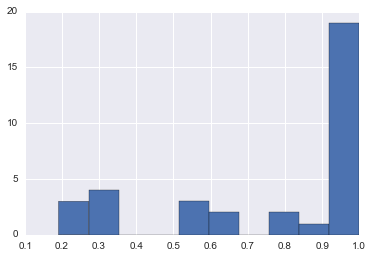

In [142]:
data = {'alpha':[],'beta':[],'sub':[],'ll':[]}
for n,out in enumerate(standard_rl_output):
    sub, o = out
    if o.success or o.message == 'Desired error not necessarily achieved due to precision loss.':      
        data['alpha'].append(scipy.stats.logistic.cdf(o.x[0]))
        data['beta'].append(o.x[3])
        data['sub'].append(sub[0])
        data['ll'].append(o.fun)
    else:
        print sub
        print o
        data['alpha'].append(np.nan)
        data['beta'].append(np.nan)
        data['sub'].append(sub[0])
        data['ll'].append(np.nan)

data = pd.DataFrame(data)
print data.mean()
print scipy.stats.ttest_1samp(data['beta'],0)
plt.hist(data['alpha'])
standard_data = data.copy(deep=True)

0.507570301204


In [334]:
data = {'alpha':[],'d':[],'beta':[],'sub':[],'ll':[]}
for n,out in enumerate(leaky_rl_output):
    sub, o = out
    if o.success:      
        data['alpha'].append(scipy.stats.logistic.cdf(o.x[0]))
        data['d'].append(scipy.stats.logistic.cdf(o.x[1]))
        data['beta'].append(o.x[4])
        data['sub'].append(sub[0])
        data['ll'].append(o.fun)

    else:
        print sub
        data['alpha'].append(np.nan)
        data['d'].append(np.nan)
        data['beta'].append(np.nan)
        data['sub'].append(sub[0])
        data['ll'].append(np.nan)
data = pd.DataFrame(data)

print data.mean()
leaky_data = data.copy(deep=True)
# plt.hist(alpha)
print scipy.stats.ttest_1samp(data['beta'],0)
# plt.hist(data['d'])
# sns.jointplot('alpha','d',data)

['fd_104']
['fd_109']
['fd_114']
['fd_115']
['fd_119']
['fd_123']
alpha      0.465444
beta      -1.859229
d          0.523060
ll       144.110728
dtype: float64
(nan, nan)


['fd_104']
['fd_108']
['fd_133']
0.546564134589
-1.04547449335
1.10433020606
(-5.4384039206998658, 5.0572747707346592e-06)


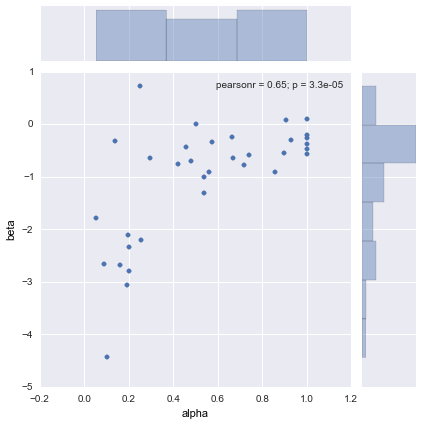

In [69]:
data = {'alpha':[],'beta':[],'sub':[]}
for n,out in enumerate(output):
    sub, o = out
    if o.success:    
        data['alpha'].append(scipy.stats.logistic.cdf(o.x[0]))
        data['beta'].append(o.x[3])
        data['sub'].append(sub[0])
    else:
        print sub
data = pd.DataFrame(data)
params = np.array(params)

print scipy.stats.ttest_1samp(V_beta,0)

sns.jointplot('alpha','beta',data)

In [ ]:

standard_data = llrt(standard_data,null_data,2)
# standard_data = llrt(leaky_data,standard_data,1)

print standard_data[standard_data['sig']==True]['alpha'].median()

#Bootstrap to get the null distribution

In [40]:
def minimize_bs(in_tuple):
    predictors,num_runs = in_tuple
    
    #perform minimization
    res = minimize(regress_all_bothexp,params,args=(predictors,num_runs,True),method='BFGS', options={'disp': True})
    return res

In [20]:
##perform bootstrapping to generate a null distribution of beta
n_samples = 250
params = [0]
params.extend(np.zeros(3))
num_runs  = 3
bootstrap_beta = False
predictors = build_df_all_bothexp(num_runs)

pred_list = []
for i in range(n_samples):
             
    #shuffle RTs
    rts = predictors[predictors['rt'].notnull()]['rt'].values
    random.shuffle(rts)
    predictors.loc[predictors['rt'].notnull(),'rt'] = rts
    
    pred_list.append((predictors.copy(),num_runs))

In [34]:
# pool = multiprocessing.Pool(processes=50)
# output = pool.map(minimize_bs,pred_list)
# pool.terminate()
# pool.join()

0.08
0.0745154252299


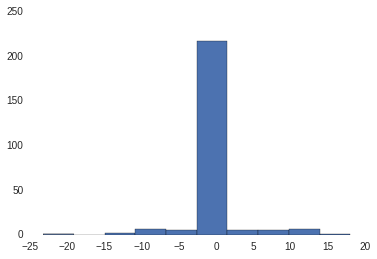

In [33]:
params = []
for n,o in enumerate(output):
    if True:#o.success:
        params.append(o.x)
    else:
        None
params = np.array(params)

# v_beta = -1.16
v_beta = -.78

a = params[:,3] < v_beta
print float(np.sum(a))/len(params[:,3])
plt.hist(params[:,3])

print np.mean(params[:,3])

In [269]:
def simulate_RL(RL_func,rl_params):
    #update experiment file with PE regressor made from the best fitting alpha
    best_alphas = {'ser':alpha, 'sim':alpha}
    best_ds = {'ser':d, 'sim':d}

    timing_info = pd.read_csv(data_dir + '/timing_info.csv', index_col =0)
    subjects = list(np.loadtxt(data_dir+ '/subjects.txt',str))

    for exp in best_alphas.keys():

        ##perform RL for the experimental condition
        for i in range(1,num_runs+1):
            event_order = exp_order[exp_order['exp']==exp]
            rew = np.array(event_order[event_order['run']==i]['rew'])
            tt = np.array(event_order[event_order['run']==i]['trial_order'])
            V, delta, index = RL_func(tt,rew,rl_params,exp)
#             if i ==1:
#                 print exp
#                 print list(tt)
#                 print list(rew)
            for key in V.keys():
                deltas = delta[key]
#                 deltas = list(deltas - np.mean(deltas)) #mean center
                Vs = V[key][:-1]
#                 Vs = list(Vs - np.mean(Vs))
                timing_info.ix[(timing_info['run'] == i) & (timing_info['condition'] == key) & \
                                     (timing_info['exp']==exp),'PE'] = deltas*len(subjects)
                timing_info.ix[(timing_info['run'] == i) & (timing_info['condition'] == key) & \
                                     (timing_info['exp']==exp),'V'] = Vs*len(subjects)
    return timing_info
# timing_info.to_csv(data_dir + '/timing_info.csv')

        alpha      beta           ll
all  0.482404 -0.389827 -4776.017111
        alpha      beta         d           ll           chi   sig
all  0.326351 -0.799081  0.425936 -4735.835321  1.576343e-19  True
        alpha    beta           ll
all  0.227885 -0.7377 -4787.764264


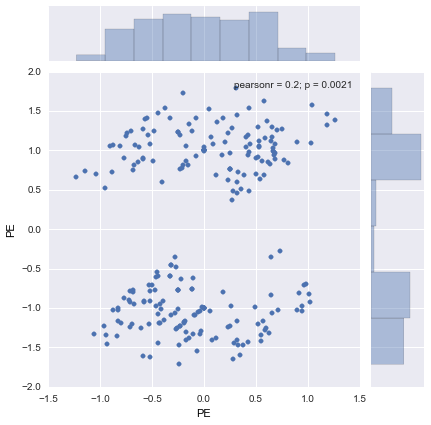

In [372]:
print standard_df
print leak_df
print dumb_df
time1 = simulate_RL(standard_RL,.48)
time2 = simulate_RL(leaky_RL,(.32,.43))
time3 = simulate_RL(dumb_RL,.23)

# time2 = simulate_RL(dumb_RL,.5)

##old timing
exp_order.ix[exp_order['rew'] == -1,'rew'] = 0 #balance reward so learning is even
time_old = simulate_RL(standard_RL,.47)
exp_order.ix[exp_order['rew'] == 0,'rew'] = -1 #balance reward so learning is even


pe1= time1[time1['sub']=='fd_104']['PE'].dropna()
pe2= time3[time1['sub']=='fd_104']['PE'].dropna()

pe_diff = pe2 - pe1

pe1_pos = np.array([x for x in pe1.values if x >0])
pe2_pos = np.array([x for n,x in enumerate(pe2.values) if pe1.values[n] >0])
# pe_old= old_time[old_time['sub']=='fd_104']['V'].dropna()
# sns.jointplot(pe1_pos,pe2_pos)
sns.jointplot(pe_diff,pe2)

#Next try bootstrapping with the best fit beta values and examine the distribution of alpha

In [45]:
# params = 0
# bootstrap_beta = True
# pool = multiprocessing.Pool(processes=75)
# output = pool.map(minimize_bs,pred_list)
# pool.terminate()
# pool.join()

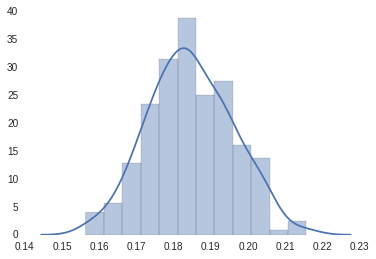

In [44]:
params = []
for n,o in enumerate(output):
    if True:#o.success:
        params.append(o.x)
    else:
        None
params = np.array(params)

params = map(lambda x: scipy.stats.logistic.cdf(x),params)
sns.distplot(params);

#Now get likelihood of a response under a q-learning model

In [19]:
def softmax(values,choice_index,beta):
    values = np.exp(values*beta)
    p_choice = values[choice_index]/np.sum(values)
    return p_choice

In [40]:
def perform_Q_RL(trial_order,rew_trial,alpha,exp):
    Q = {('b_plus','go'):[0],('b_plus','NoGo'):[0], ('b_minus','go'):[0],('b_minus','NoGo'):[0],
         ('c_plus','go'):[0],('c_plus','NoGo'):[0], ('c_minus','go'):[0],('c_minus','NoGo'):[0]}
    delta = {('b_plus','go'):[0],('b_plus','NoGo'):[0], ('b_minus','go'):[0],('b_minus','NoGo'):[0],
         ('c_plus','go'):[0],('c_plus','NoGo'):[0], ('c_minus','go'):[0],('c_minus','NoGo'):[0]}
    index = {('b_plus','go'):[0],('b_plus','NoGo'):[0], ('b_minus','go'):[0],('b_minus','NoGo'):[0],
         ('c_plus','go'):[0],('c_plus','NoGo'):[0], ('c_minus','go'):[0],('c_minus','NoGo'):[0]}    
    
    order_dict = order_dict_exp[exp]
    count = 0
    for n,cond in enumerate(trial_order):
        trial_type = None
        for key in order_dict:
            if order_dict[key] == cond:
                trial_type = key
                
        if trial_type is not None:
            trial_rt = predictors[predictors['cond']==trial_type]['rt'][n] #get RT for this trial
            rew_outcome = rew_trial[n]
            if np.isnan(trial_rt):
                action = 'NoGo'
            else:
                action = 'Go'
            
            if action == 'Go' and rew_outcome == 0: #false alarm
                rew  = -1
            elif action == 'Go' and rew_outcome == 1: #response, target
                rew = 1
            elif action == 'NoGo': #no response
                rew = 0           
            
            delta[(trial_type,action)].append(rew - Q[(trial_type,action)][-1]) #compute PE
            new_Q = Q[(trial_type,action)][-1] + alpha * delta[(trial_type,action)][-1] #calculate V for next trial
            Q[(trial_type,action)].append(new_Q) 
            index[(trial_type,action)].append(count)
            count += 1 

    return Q, delta, index

In [43]:
#compute loss for RL model
def choice_likelihood(trial_order,rew_trial,alpha,exp):
    
    alpha = scipy.stats.logistic.cdf(params[0]) #learning rate
    beta = params[2]
    Q = perform_Q_RL(trial_order,rew_trial,alpha,exp): #get values from RL         

    #compute LL under softmax
    ll = 0
    for i in range(ntrials):
        p_choice = softmax(Q[i,:],choices[i],beta)
        ll += np.log(p_choice)
        
    ll = ll*-1 #minimize neg LL
    
    return ll

In [ ]:
params = [0]
params.extend(np.zeros(3))
num_runs  = 3
# predictors = build_df_all(num_runs,exp)
predictors = build_df_all_bothexp(num_runs)

#minimize
# res = minimize(regress_all,params,args=(predictors,num_runs,exp),method='BFGS', options={'disp': True})
res = minimize(regress_all_bothexp,params,args=(predictors,num_runs,False),method='BFGS', options={'disp': True})